# The Convolutional Neural Network for Redshift pattern

### Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
import shutil
import random
from space_agent.interface.interface_main import create_rotated_images, copy_images_sorted
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


### Data balancing function

In [3]:
def generate_balanced_dataset(
    galaxy_dir,
    star_dir,
    galaxy_aug_dir,
    star_aug_dir,
    balanced_dir
):
    # Ensure the balanced directory exists
    if not os.path.exists(balanced_dir):
        os.makedirs(balanced_dir)
    # Get the list of files in each directory
    galaxy_files = os.listdir(galaxy_dir)
    star_files = os.listdir(star_dir)
    galaxy_aug_files = os.listdir(galaxy_aug_dir)
    star_aug_files = os.listdir(star_aug_dir)
    # Count the number of images in each directory
    galaxy_count = len(galaxy_files)
    star_count = len(star_files)
    galaxy_aug_count = len(galaxy_aug_files)
    star_aug_count = len(star_aug_files)
    # Copy all original images to the balanced directory
    for file in galaxy_files:
        shutil.copy(os.path.join(galaxy_dir, file), balanced_dir)
    for file in star_files:
        shutil.copy(os.path.join(star_dir, file), balanced_dir)
    if galaxy_aug_count > star_aug_count:
        # Copy all star augmented images to the balanced directory
        for file in star_aug_files:
            shutil.copy(os.path.join(star_aug_dir, file), balanced_dir)
        # Copy star_aug_count - (galaxy_count - star_count) galaxy augmented images to the balanced directory
        additional_files = random.sample(galaxy_aug_files, star_aug_count - (galaxy_count - star_count))
        for file in additional_files:
            shutil.copy(os.path.join(galaxy_aug_dir, file), balanced_dir)
    else:
        # Copy all galaxy augmented images to the balanced directory
        for file in galaxy_aug_files:
            shutil.copy(os.path.join(galaxy_aug_dir, file), balanced_dir)
        # Copy galaxy_aug_count - (star_count - galaxy_count) star augmented images to the balanced directory
        additional_files = random.sample(star_aug_files, galaxy_aug_count - (star_count - galaxy_count))
        for file in additional_files:
            shutil.copy(os.path.join(star_aug_dir, file), balanced_dir)

### Data augmentation

In [6]:
create_rotated_images()

index: 0 - rc: 0 - rotated copies of 1237664673256571815_206.152742248973_35.7832473187171_GALAXY_1.010923 saved to GALAXY
index: 1 - rc: 0 - rotated copies of 1237678597545591138_341.669732121639_2.68301678396564_STAR_1.209123 saved to STAR
index: 2 - rc: 0 - rotated copies of 1237661971714802594_167.43558751989_7.25414879542971_GALAXY_0.6665187 saved to GALAXY
index: 3 - rc: 0 - rotated copies of 1237678661426872832_6.57664509322581_4.68786591849795_STAR_2.225737 saved to STAR
index: 4 - rc: 0 - rotated copies of 1237680272035807907_331.937003344296_19.1261163729245_STAR_0.0001422011 saved to STAR
index: 5 - rc: 0 - rotated copies of 1237671257982959869_71.7395540497452_22.8695598593538_STAR_-8.090883E-05 saved to STAR
index: 6 - rc: 0 - rotated copies of 1237663789028409683_116.929808014175_51.28220380126_GALAXY_0.1862477 saved to GALAXY
index: 7 - rc: 0 - rotated copies of 1237680275799212442_6.26243031097539_26.8156110992586_STAR_2.767038 saved to STAR
index: 8 - rc: 0 - rotated c

### Prepare balancing

In [7]:
copy_images_sorted()

index: 0 - image 1237664673256571815_206.152742248973_35.7832473187171_GALAXY_1.010923.jpg copied to GALAXY
index: 1 - image 1237678597545591138_341.669732121639_2.68301678396564_STAR_1.209123.jpg copied to STAR
index: 2 - image 1237661971714802594_167.43558751989_7.25414879542971_GALAXY_0.6665187.jpg copied to GALAXY
index: 3 - image 1237678661426872832_6.57664509322581_4.68786591849795_STAR_2.225737.jpg copied to STAR
index: 4 - image 1237680272035807907_331.937003344296_19.1261163729245_STAR_0.0001422011.jpg copied to STAR
index: 5 - image 1237671257982959869_71.7395540497452_22.8695598593538_STAR_-8.090883E-05.jpg copied to STAR
index: 6 - image 1237663789028409683_116.929808014175_51.28220380126_GALAXY_0.1862477.jpg copied to GALAXY
index: 7 - image 1237680275799212442_6.26243031097539_26.8156110992586_STAR_2.767038.jpg copied to STAR
index: 8 - image 1237666301632512172_57.5976223070929_0.822063361286141_GALAXY_0.1848572.jpg copied to GALAXY
index: 9 - image 1237680275797901779_2

### Balancing

In [8]:
image_star_dir = "../data/images_cropped_sorted/STAR"
image_galaxy_dir = "../data/images_cropped_sorted/GALAXY"
image_star_aug_dir = "../data/images_cropped_from_augmentation/STAR"
image_galaxy_aug_dir = "../data/images_cropped_from_augmentation/GALAXY"
image_bal_dir = "../data/images_final"

generate_balanced_dataset(
    image_galaxy_dir,
    image_star_dir,
    image_galaxy_aug_dir,
    image_star_aug_dir,
    image_bal_dir
)

In [10]:
#image_dir = os.environ['IMAGE_FINAL']
#image_dir

### X & y creation

In [11]:

image_dir = '../data/images_final'

#image_files = [f for f in listdir(image_dir) if isfile(join(image_dir, f))]

image_files = []
for f in listdir(image_dir):
    if isfile(os.path.join(image_dir, f)):
        if f.endswith(".jpg"):
            image_files.append(f)
        else:
            print("not jpg ignored")

X_list = []
y_list_rs = []
for image_file in image_files:
    image_info = image_file.replace('.jpg', '').split("_")
    cat_rs = image_info[4]
    image_data = np.array(Image.open(os.path.join(image_dir,image_file)))
    X_list.append(image_data)
    y_list_rs.append(cat_rs)

print(y_list_rs)
X_data = np.array(X_list)
print(X_data.shape)
y_data_rs = np.array(y_list_rs)
print(y_data_rs.shape)

['1.010923', '1.040037', '0.2860934', '-0.0001686188', '0.09963445', '1.209123', '7.566335E-05', '0.07972629', '0.5066113', '0.6859798', '0.6665187', '0.0004263824', '2.082755', '2.225737', '0.0004075449', '0.5190644', '0.0003305929', '0.0001422011', '-8.090883E-05', '1.066125', '0.5281535', '2.701146', '0.7552643', '0.7336797', '0.8063799', '0.5103259', '0.5939884', '0.6226482', '1.166883', '0.0003134053', '0.07020438', '0.5050672', '0.4801632', '0.4869024', '0.1728631', '1.72023', '0.0001422011', '0.1390517', '0.1862477', '0.1655436', '0.5896075', '0.1424896', '2.767038', '1.018138', '0.1415183', '0.08869503', '0.1848572', '0.350847', '0.3038332', '0.2391574', '1.512483', '-0.001506516', '0.6223869', '0.1390098', '0.1351734', '-0.0003176941', '0.669324', '0.09023475', '0.3165901', '0.2505086', '0.6185887', '0.956165', '0.3351592', '2.914261', '0.7328814', '2.069323', '0.2219528', '0.628804', '0.0922523', '0.1724996', '1.134754', '1.095877', '0.5601146', '0.584038', '0.0001266983', '0

### Train test split

In [12]:
# Split the dataset
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(
    X_data,
    y_data_rs,
    test_size=0.3,
    random_state=42
)

### Models definitions

In [14]:
model_rs_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])
model_rs_2 = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(20, activation='relu'),
    Dense(1, activation='linear')
])
model_rs_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])
model_rs_4 = Sequential([
    Conv2D(64, (4, 4), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(15, activation='relu'),
    Dense(1, activation='linear')
])
model_rs_5 = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])

### Models compilation

In [15]:
# Compile the models
models_rs = [model_rs_1, model_rs_2, model_rs_3, model_rs_4, model_rs_5]
for i, model_rs in enumerate(models_rs, start=1):
    model_rs.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    print(f"Model {i} compiled.")


Model 1 compiled.
Model 2 compiled.
Model 3 compiled.
Model 4 compiled.
Model 5 compiled.


### X shape verif

In [17]:
X_data.shape

(21147, 128, 128, 3)

### Baseline

In [18]:
y_train_rs.astype(float).mean()

0.6133135198866737

### Model 1 training

In [20]:
es = EarlyStopping(patience=5)

history_rs = model_rs_1.fit(
    X_train_rs,
    y_train_rs.astype(float),
    batch_size=16,
    epochs=10,
    validation_split=0.3,
    callbacks=[es]
)

Epoch 1/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 6490.1587 - mae: 7.2334 - mse: 6490.1587 - val_loss: 0.9862 - val_mae: 0.6194 - val_mse: 0.9862
Epoch 2/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.9661 - mae: 0.6018 - mse: 0.9661 - val_loss: 0.9583 - val_mae: 0.6067 - val_mse: 0.9583
Epoch 3/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.9217 - mae: 0.5803 - mse: 0.9217 - val_loss: 0.9186 - val_mae: 0.5891 - val_mse: 0.9186
Epoch 4/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.8651 - mae: 0.5683 - mse: 0.8651 - val_loss: 0.8688 - val_mae: 0.5701 - val_mse: 0.8688
Epoch 5/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.7692 - mae: 0.5307 - mse: 0.7692 - val_loss: 0.8118 - val_mae: 0.5516 - val_mse: 0.8118
Epoch 6/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 0.7506 - mae: 0.5212 - mse: 0.7506 - val_loss: 0.7532 - val_mae: 0.5349 - val_mse: 0.7532
Epoch 7/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.7184 - mae: 0.5111

### Model 1 plot

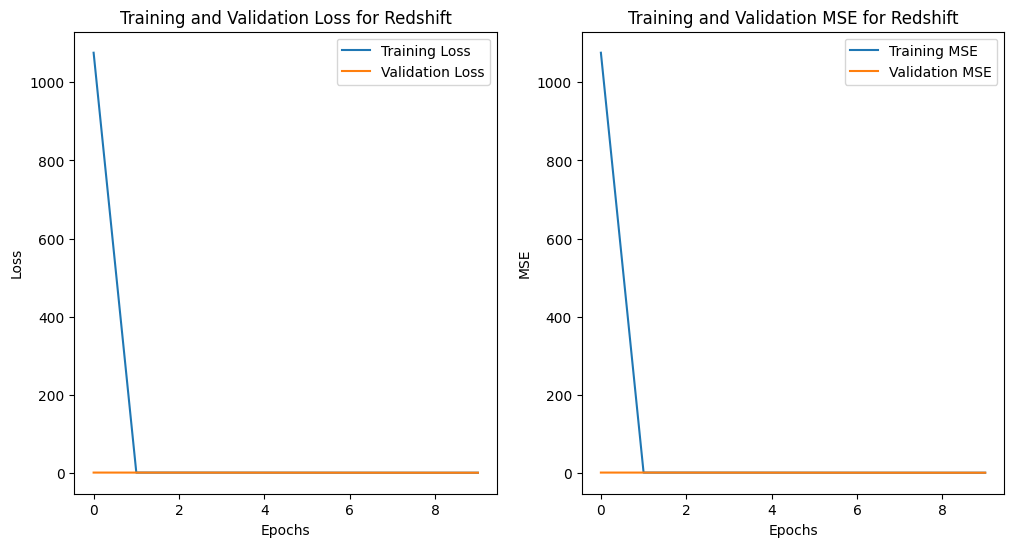

In [22]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_rs.history['loss'], label='Training Loss')
plt.plot(history_rs.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Redshift')
plt.legend()

# Plot the training and validation MSE
plt.subplot(1, 2, 2)
plt.plot(history_rs.history['mse'], label='Training MSE')
plt.plot(history_rs.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE for Redshift')
plt.legend()

plt.show()

### Models 2,3,4,5 training

In [23]:
# Define the EarlyStopping callback
es = EarlyStopping(patience=5)

# Placeholder for storing histories
histories_rs = []

# Train each model and store the history
for i, model_rs in enumerate(models_rs, start=1):
    print(f"Training Model {i}...")
    history_rs = model_rs.fit(
        X_train_rs,
        y_train_rs.astype(float),
        batch_size=16,
        epochs=10,
        validation_split=0.2,
        callbacks=[es]
    )
    histories_rs.append(history_rs)
    print(f"Model {i} trained.")

Training Model 1...
Epoch 1/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.6207 - mae: 0.5256 - mse: 0.6207 - val_loss: 0.6171 - val_mae: 0.5318 - val_mse: 0.6171
Epoch 2/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.6140 - mae: 0.5354 - mse: 0.6140 - val_loss: 0.6161 - val_mae: 0.5372 - val_mse: 0.6161
Epoch 3/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - loss: 0.6314 - mae: 0.5427 - mse: 0.6314 - val_loss: 0.6160 - val_mae: 0.5385 - val_mse: 0.6160
Epoch 4/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - loss: 0.6067 - mae: 0.5351 - mse: 0.6067 - val_loss: 0.6157 - val_mae: 0.5419 - val_mse: 0.6157
Epoch 5/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.6201 - mae: 0.5467 - mse: 0.6201 - val_loss: 0.6164 - val_mae: 0.5349 - val_mse: 0.6164
Epoch 6/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - loss: 0.5738 - mae: 0.5229 - mse: 0.5738 - val_loss: 0.6157 - val_mae: 0.5422 - val_mse: 0.6157
Epoch 7/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.6098

### Models plots 

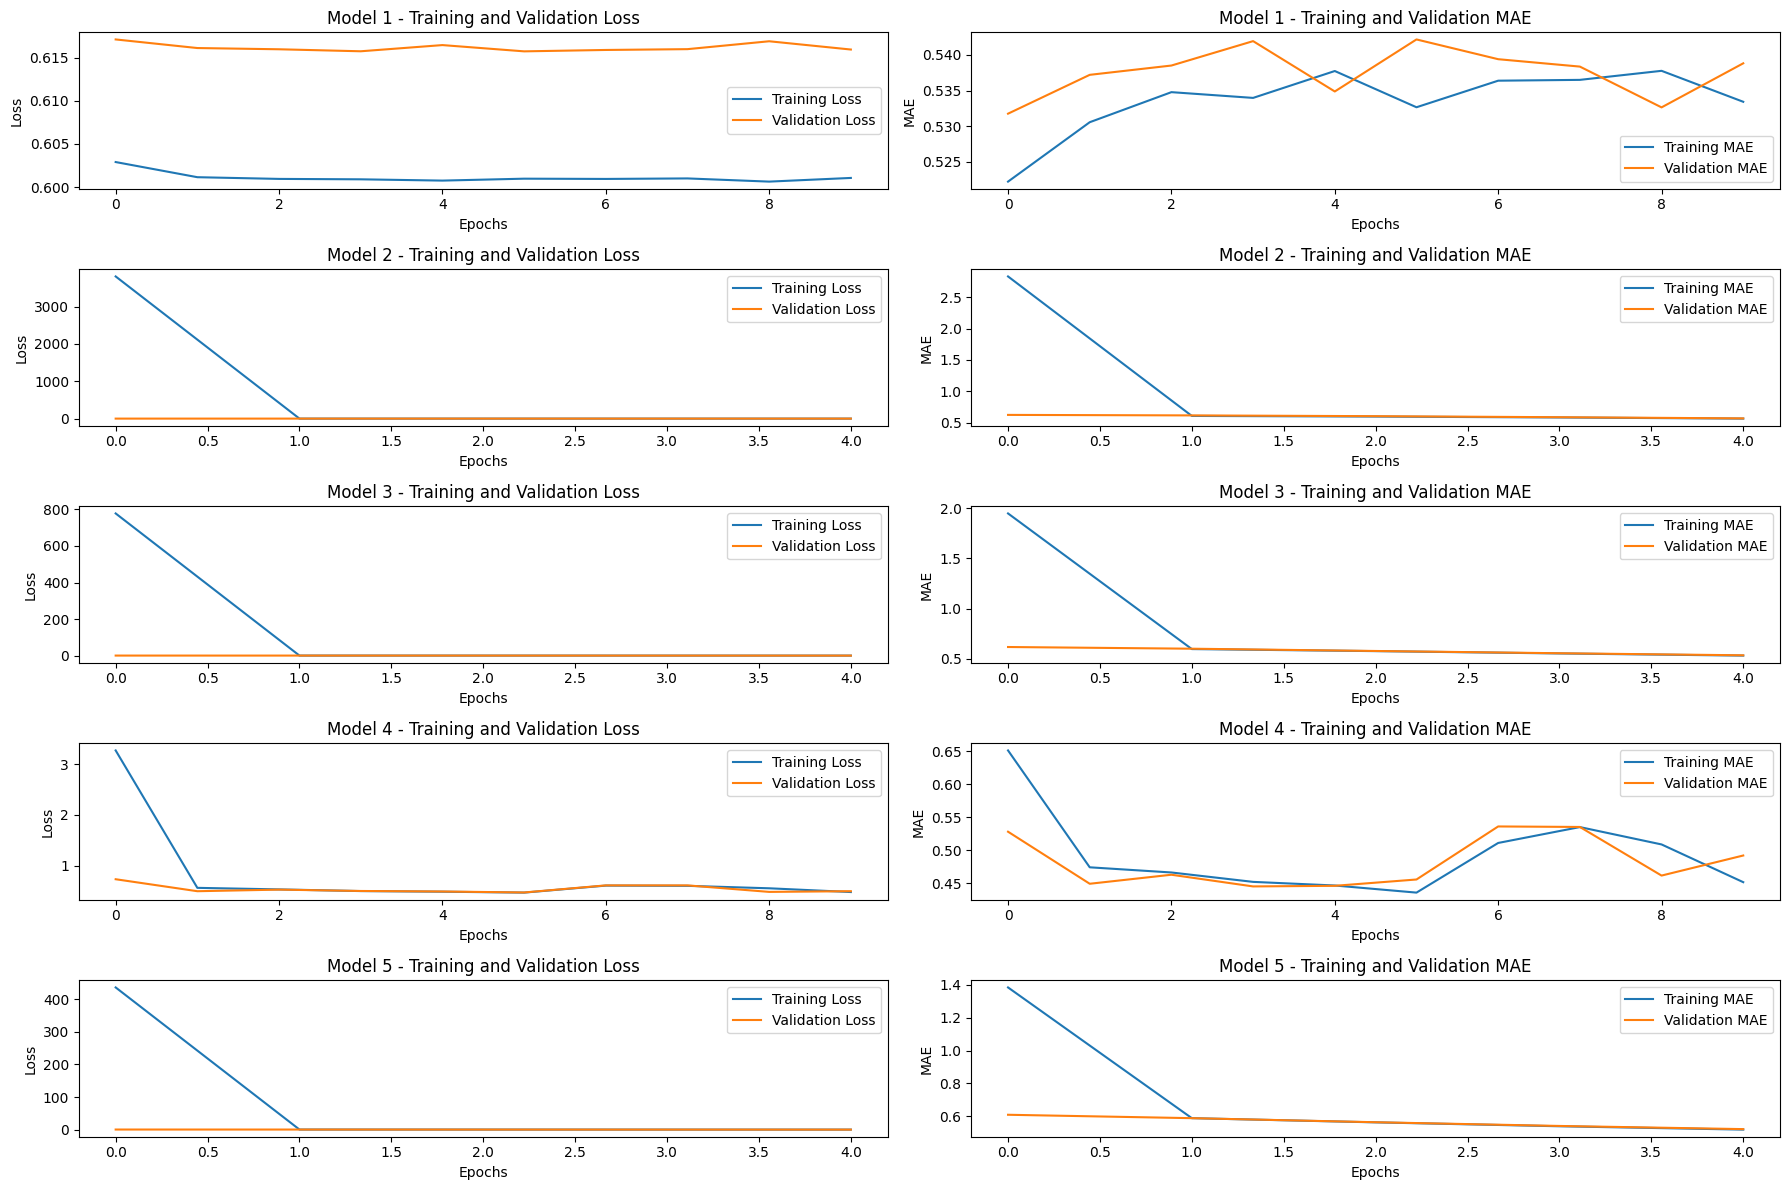

In [25]:
# Plot the training and validation loss and accuracy for all models
plt.figure(figsize=(18, 12))

for i, history_rs in enumerate(histories_rs, start=1):
    plt.subplot(5, 2, i * 2 - 1)
    plt.plot(history_rs.history['loss'], label='Training Loss')
    plt.plot(history_rs.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model {i} - Training and Validation Loss')
    plt.legend()

    plt.subplot(5, 2, i * 2)
    plt.plot(history_rs.history['mae'], label='Training MAE')
    plt.plot(history_rs.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title(f'Model {i} - Training and Validation MAE')
    plt.legend()

plt.tight_layout()
plt.show()

### Models export

In [26]:
model_rs_4.save('../models/rs4.h5')
model_rs_4.save('../models/rs4.keras')